In [120]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch import optim
import albumentations as A
from albumentations.pytorch import ToTensorV2

torch.backends.cudnn.benchmark = True
scaler = torch.cuda.amp.GradScaler()

/Users/silas/work/nest/nest_env/lib/python3.12/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [121]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device}")

Using mps


In [ ]:
run_test_cases = False # Set to True if debugging is required
cloud_labels = ["Flower", "Gravel", "Fish", "Sugar"] # All possible labels for the clouds

# Original Image resolutions
in_res_y = 1400
in_res_x = 2100

# New Image resolutions
new_res_y = 512
new_res_x = 768

# data directories
test_dir = "./test_images"
train_dir = "./train_images"

# Training params
num_filters = 24 # Number of filters in first conv layer  
num_train_images = 128
num_test_images = 32

batch_size = 8
num_epochs = 40
lr = 1e-4

In [123]:
image_names = os.listdir(train_dir)

train_images = image_names[:num_train_images]
test_images = image_names[num_train_images:num_train_images+num_test_images]
print(test_images)

df = pd.read_csv('train.csv')
df[['Image', 'Label']] = df['Image_Label'].str.split('_', expand=True)

if run_test_cases:
    print(df[['Image', 'Label', 'EncodedPixels']].head(8))
    print()
    print(df['Image'].unique()[:10])

['af4d36b.jpg', 'ebe596d.jpg', '423c22d.jpg', '61259d9.jpg', 'bacd6fe.jpg', '1230c60.jpg', '4b8a262.jpg', '3614409.jpg', '3361513.jpg', '7473a71.jpg', 'f431307.jpg', '0e42958.jpg', '4e5b275.jpg', 'a1d13fa.jpg', '57559fb.jpg', 'df426c2.jpg', '6e1e7cb.jpg', 'a00ab01.jpg', '5e70a5b.jpg', '6d9de9e.jpg', 'd836ac5.jpg', '19807b1.jpg', '5683db4.jpg', '40dd239.jpg', '87a1831.jpg', 'fa12d07.jpg', '741dcf3.jpg', 'e3b3009.jpg', '2d2bd73.jpg', 'd2eb9fe.jpg', 'de2c9bb.jpg', 'cea2726.jpg']
         Image   Label                                      EncodedPixels
0  0011165.jpg    Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg  Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg  Gravel                                                NaN
3  0011165.jpg   Sugar                                                NaN
4  002be4f.jpg    Fish  233813 878 235213 878 236613 878 238010 881 23...
5  002be4f.jpg  Flower  1339279 519 1340679 519 1342079 519 1343479 51...
6

In [124]:
# Get labels and rle from image name
def get_labels_rle(image_name: str, df) -> list:
    rles = df[df['Image'] == image_name]['EncodedPixels'].to_list()
    labels = df[df['Image'] == image_name]['Label'].to_list()
    return rles, labels

# Debugging
if run_test_cases:

    # Get Files
    train_images = os.listdir(train_dir)[:2]
    print(f"Train images: {train_images}")

    for image in train_images:
        rles, labels = get_labels_rle(f"{image}", df)
        for rle, label in zip(rles, labels):
            print(f"Label: {label} \n rle: {rle} \n")

Train images: ['8734e73.jpg', '0ece863.jpg']
Label: Fish 
 rle: nan 

Label: Flower 
 rle: 642862 632 644262 632 645662 632 647062 632 648462 632 649862 632 651262 632 652662 632 654062 632 655462 632 656862 632 658262 632 659662 632 661062 632 662462 632 663862 632 665262 632 666662 632 668062 632 669462 632 670862 632 672262 632 673662 632 675062 632 676462 632 677862 632 679262 632 680662 632 682062 632 683462 632 684862 632 686262 632 687662 632 689062 632 690462 632 691862 632 693262 632 694662 632 696062 632 697462 632 698862 632 700262 632 701662 632 703062 632 704462 632 705862 632 707262 632 708662 632 710062 632 711462 632 712862 632 714262 632 715662 632 717062 632 718462 632 719862 632 721262 632 722662 632 724062 632 725462 632 726862 632 728262 632 729662 632 731062 632 732462 632 733862 632 735262 632 736662 632 738062 632 739462 632 740862 632 742262 632 743662 632 745062 632 746462 632 747862 632 749262 632 750662 632 752062 632 753462 632 754862 632 756262 632 757662 

Train images: ['8734e73.jpg', '0ece863.jpg']


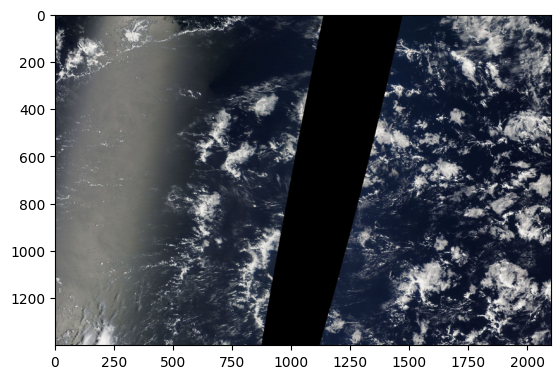

[0.]
titel: Fish


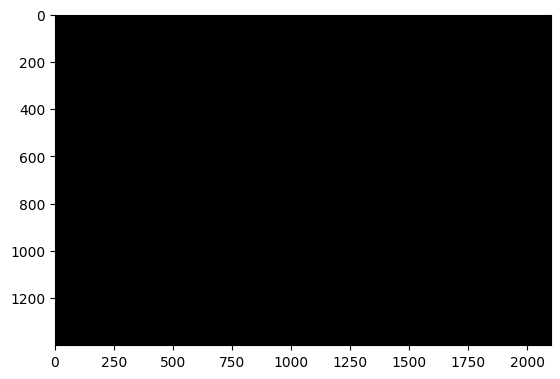

[0. 1.]
titel: Flower


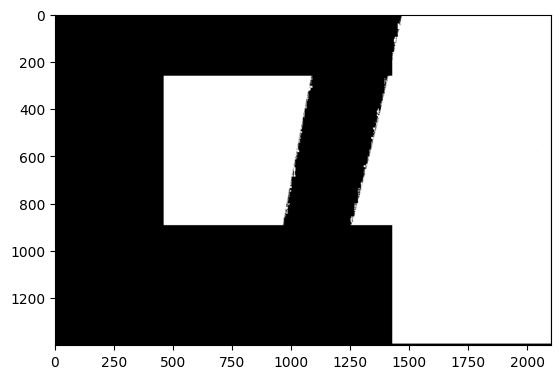

[0.]
titel: Gravel


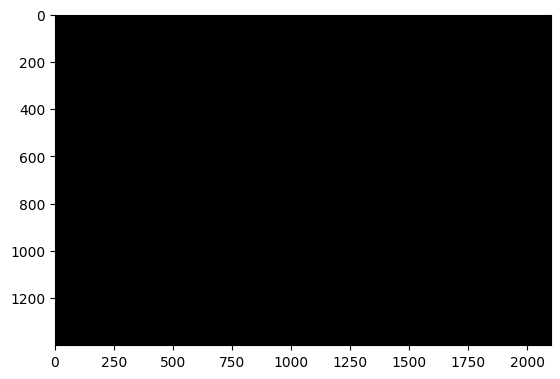

[0.]
titel: Sugar


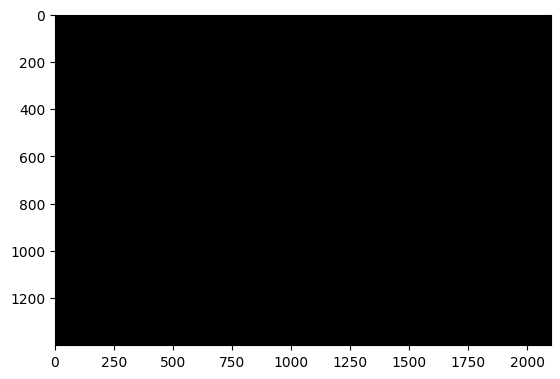

---------------------------------


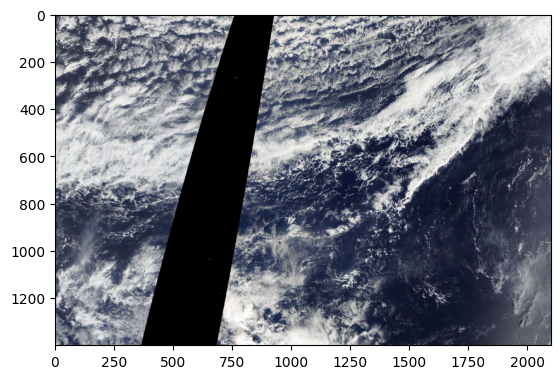

[0.]
titel: Fish


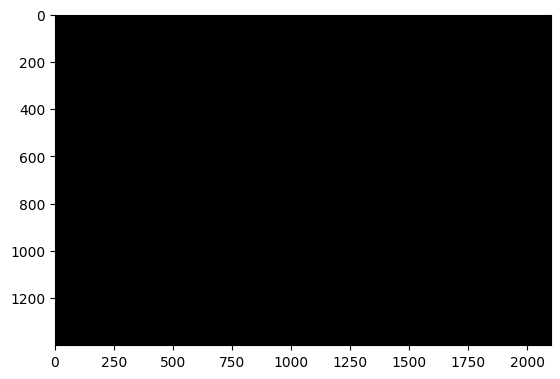

[0.]
titel: Flower


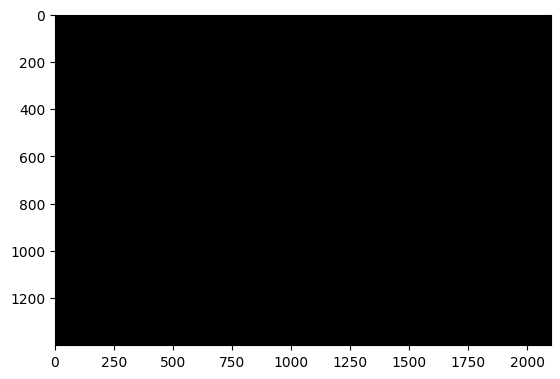

[0. 1.]
titel: Gravel


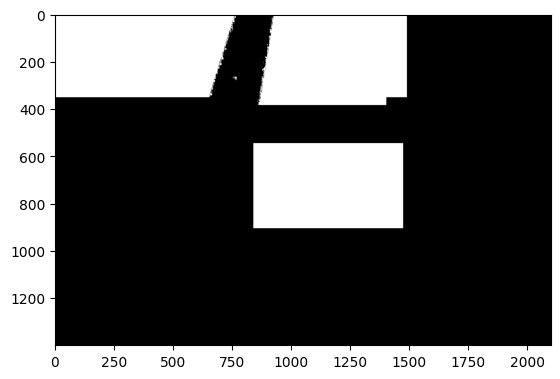

[0. 1.]
titel: Sugar


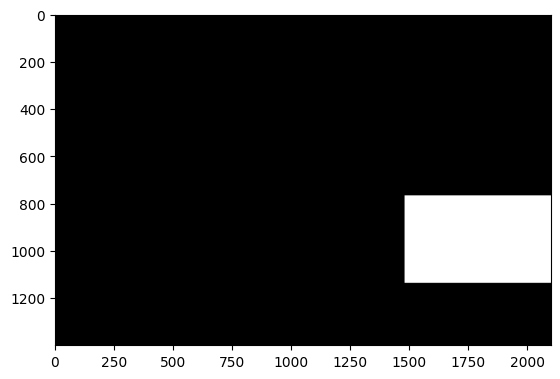

---------------------------------


In [125]:
# Convert rle mask encoding into 2D arrays
def rle_to_array(rle_list: list) -> np.array:

    # Create empty array for
    array = np.zeros(in_res_y * in_res_x)

    # Skip if cloud formation is not on picture
    if not rle_list or pd.isna(rle_list):
        mask = array.reshape((in_res_x, in_res_y), order="A").T
        return mask
    
    rle_array = np.array(list(map(int, rle_list.split())), dtype=int)
    start_pixels = rle_array[::2] - 1 # Offset because pixel 1 is arr position 0
    num_pixels = rle_array[1::2]

    # Create 2D mask
    for start_pixel, num_pixels in zip(start_pixels, num_pixels): # Format is [start_idx_0, num_pixels_0 ...]
        array[start_pixel:start_pixel+num_pixels] = 1.0
    
    # Reshape
    mask = array.reshape((in_res_x, in_res_y), order="A").T # 2D array of [Height, Width]

    return mask

# For debugging
if run_test_cases:

    # Get Files
    train_images = os.listdir(train_dir)[:2]
    print(f"Train images: {train_images}")

    # Plot files
    for image_name in train_images:
        img = cv2.imread(f"{train_dir}/{image_name}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        rles, labels = get_labels_rle(image_name, df)

        # Raw Image
        plt.imshow(img)
        plt.show()

        for rle, label in zip(rles, labels):

            # Masked Image
            mask = rle_to_array(rle)
            print(np.unique(mask))
            print(f"titel: {label}")
            plt.imshow(mask, cmap="grey", vmin=0.0, vmax=1.0)
            #plt.imshow(mask[:, :, None].repeat(3, axis=-1)*img, cmap="grey", vmin=0.0, vmax=1.0)
            plt.show()
        print("---------------------------------")

In [126]:
def dice_coef(preds, target, eps=1e-6):
    # [B, 4, H, W]

    preds = torch.sigmoid(preds)
    overlap = (preds * target).sum((2,3))

    dice = (2. * overlap + eps) / (preds.sum((2,3)) + target.sum((2,3)) + eps)

    return dice.mean()

In [127]:
def dice_loss(preds, target, eps=1e-6):
    return 1 - dice_coef(preds, target, eps=eps)

In [128]:
bce_loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5.0]).to(device))

In [129]:
def loss_fn(preds, target, eps=1e-6):
    return 0.25 * dice_loss(preds, target, eps) + 0.75 * bce_loss(preds, target)

In [130]:
train_transform = A.Compose([
    # --- geometric transforms ---
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    #A.Transpose(p=0.2),

    # --- photometric transforms ---
    A.RandomBrightnessContrast(p=0.1),
    #A.GaussNoise(p=0.2),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.2),

    # --- spatial transforms ---
    A.ShiftScaleRotate(
        shift_limit=0.02,
        scale_limit=0.05,
        rotate_limit=10,
        border_mode=cv2.BORDER_REFLECT,
        p=0.3
    ),

    # --- normalization ---
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),

    # --- ensure correct shape ---
    A.Resize(height=new_res_y, width=new_res_x, always_apply=True),

    # --- to tensor ---
    ToTensorV2(),
])

val_transform = A.Compose([
    # --- normalization ---
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),

    # --- ensure correct shape ---
    A.Resize(height=new_res_y, width=new_res_x, always_apply=True),

    # --- to tensor ---
    ToTensorV2(),
])



/Users/silas/work/nest/nest_env/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_64079/3775102026.py:27: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=new_res_y, width=new_res_x, always_apply=True),
/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_64079/3775102026.py:39: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=new_res_y, width=new_res_x, always_apply=True),


In [131]:
class ImageDataset(Dataset):
    def __init__(self, data_frame, img_dir, image_names, transform=None):
        self.img_dir = img_dir
        self.image_names = image_names
        self.data_frame = data_frame
        self.transform = transform

    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx): 
        image_name = self.image_names[idx]

        # --- Load image ---
        image = cv2.imread(f"{self.img_dir}/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # --- Downsample image ---
        image = cv2.resize(image, (new_res_x, new_res_y), interpolation=cv2.INTER_AREA)
        image = image.astype(np.float32)

        rles, _ = get_labels_rle(image_name, self.data_frame)

        # --- Create mask ---
        mask = np.zeros((4, in_res_y, in_res_x), dtype=np.float32)
        for i, rle in enumerate(rles):
            single_mask = rle_to_array(rle)
            mask[i, :, :] = single_mask

        # --- Downsample mask per channel ---
        mask_resized = np.zeros((4, new_res_y, new_res_x), dtype=np.float32)
        for i in range(4):
            mask_resized[i, :, :] = cv2.resize(
                    mask[i],
                    (new_res_x, new_res_y),
                    interpolation=cv2.INTER_NEAREST
                )
        mask = mask_resized

        # --- Transformations ---
        if self.transform:
            # Albumentations needs [H, W, C]
            transformed = self.transform(
                image=image,
                mask=mask.transpose(1, 2, 0)
            )
            image = transformed["image"]
            mask = transformed["mask"].permute(2, 0, 1)  # [C, H, W]

        # --- Convert to torch tensors ---
        image = torch.from_numpy(image).permute(2, 0, 1).float() if not torch.is_tensor(image) else image
        mask = torch.from_numpy(mask).float() if not torch.is_tensor(mask) else mask

        return image, mask


In [132]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, conv_kernel_size, padding):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, conv_kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, conv_kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
            )

    def forward(self, x):
        output = self.conv_block(x)
        return output # [batch, out_channels, H_out, W_out]


In [133]:
class PoolBlock(nn.Module):
    def __init__(self, downsample):
        super().__init__()

        self.pool = nn.MaxPool2d(downsample)

    def forward(self, x):
        output = self.pool(x)
        return output

In [134]:
class UpSampleBlock(nn.Module):
    def __init__(self, channels, upsample):
        super().__init__()

        self.up_sample_block = nn.Sequential(
            nn.Upsample(scale_factor=upsample, mode='bilinear', align_corners=False),
            nn.Conv2d(channels, channels // upsample, kernel_size=1)
        )

    def forward(self, x):
        upsample_block = self.up_sample_block(x)
        return upsample_block

In [135]:
class Network(nn.Module):
    def __init__(self, filters):
        super().__init__()

        # in_channels, out_channels, conv_kernel_size, padding, pool_kernel_size
        self.encoder_layer_0 = ConvolutionBlock(3, filters, 3, 1)
        self.encoder_layer_1 = ConvolutionBlock(filters, 2*filters, 3, 1)
        self.encoder_layer_2 = ConvolutionBlock(2*filters, 4*filters, 3, 1)

        self.pool_block_0 = PoolBlock(downsample=2)
        self.pool_block_1 = PoolBlock(downsample=2)
        self.pool_block_2 = PoolBlock(downsample=2)

        self.bottle_neck = nn.Conv2d(4*filters, 8*filters, 3, padding=1)

        # in_channels, out_channels, conv_kernel_size, stride
        self.decoder_layer_2 = ConvolutionBlock(8*filters, 4*filters, 3, 1)
        self.decoder_layer_1 = ConvolutionBlock(4*filters, 2*filters, 3, 1)
        self.decoder_layer_0 = ConvolutionBlock(2*filters, filters, 3, 1)

        self.up_sample_block2 = UpSampleBlock(8 * filters, upsample=2)
        self.up_sample_block1 = UpSampleBlock(4 * filters, upsample=2)
        self.up_sample_block0 = UpSampleBlock(2 * filters, upsample=2)

        self.output_layer = nn.Conv2d(filters, 4, 1)

    def forward(self, x): # [Batch, Color, Height, Width]
        
        enc0 = self.encoder_layer_0(x) # [B, num_filters, H, W]
        pool0 = self.pool_block_0(enc0) # [B, num_filters, H / 2, W / 2]

        enc1 = self.encoder_layer_1(pool0) # [B, 2 * num_filters, H / 2, W / 2]
        pool1 = self.pool_block_1(enc1) # [B, 2 * num_filters, H / 4, W / 4]

        enc2 = self.encoder_layer_2(pool1) # [B, 4 * num_filters, H / 4, W / 4]
        pool2 = self.pool_block_2(enc2) # [B, 4 * num_filters, H / 8, W / 8]

        bottle_neck = self.bottle_neck(pool2) # [B, 4 * num_filters, H / 4, W / 4]

        up2 = self.up_sample_block2(bottle_neck) # [B, 4 * num_filters, H / 4, W / 4]
        concat2 = torch.cat([up2, enc2], dim=1) # [B, 8 * num_filters, H / 4, W / 4]
        dec2 = self.decoder_layer_2(concat2) # [B, 4 * num_filters, H / 4, W / 4]

        up1 = self.up_sample_block1(dec2) # [B, 2 * num_filters, H / 2, W / 2]
        concat1 = torch.cat([up1, enc1], dim=1) # [B, 4 * num_filters, H / 2, W / 2]
        dec1 = self.decoder_layer_1(concat1) # [B, 2 * num_filters, H / 2, W / 2]

        up0 = self.up_sample_block0(dec1) # [B, num_filters, H, W]
        concat0 = torch.cat([up0, enc0], dim=1) # [B, 2 * num_filters, H, W]
        dec0 = self.decoder_layer_0(concat0) # [B, num_filters, H, W]

        logits = self.output_layer(dec0) # [B, 4, H, W]

        return logits

In [136]:
# Datasets and DataLoader
train_dataset = ImageDataset(df, train_dir, train_images, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)

test_dataset = ImageDataset(df, train_dir, test_images, transform=val_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)

In [137]:
model = Network(num_filters).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

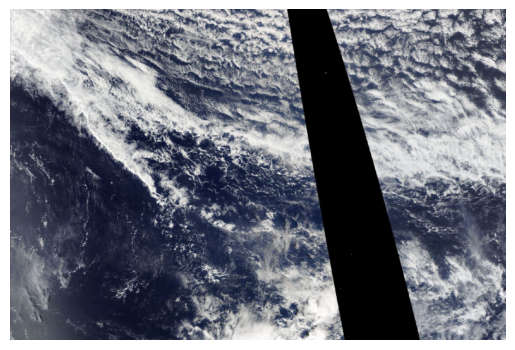

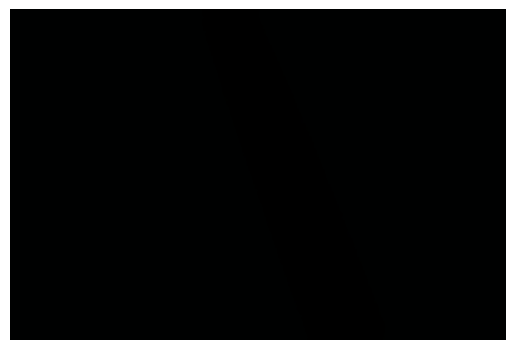

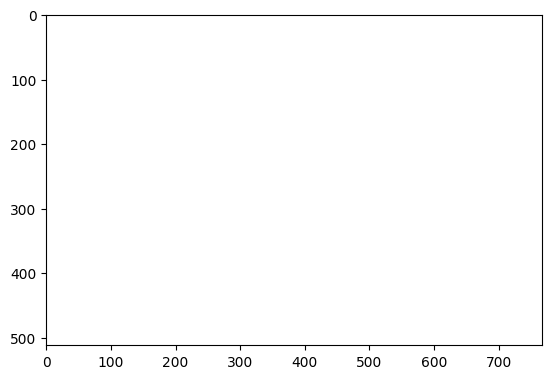

In [ ]:
# Albumentations ImageNet stats
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def denormalize(img_tensor):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = std * img + mean  # undo normalization
    img = np.clip(img, 0, 1)
    return img

if run_test_cases:
    i = 0
    num_images = 5    

    for image, mask in train_dataloader:
        # Move batch tensors to device
        image, mask = image.to(device), mask.to(device)

        # Loop over images in the batch
        for img, msk in zip(image, mask):
            # Convert tensor -> NumPy for display
            
            plt.imshow(denormalize(img))
            plt.axis('off')
            plt.show()
            plt.imshow(msk.permute(1, 2, 0).cpu().numpy(), vmin=0.0, vmax=1.0)

            i += 1
            if i == num_images:
                break

In [139]:
# Training loop
for epoch in range(num_epochs):

    # Training
    model.train()
    train_loss = 0.0
    
    for image, mask in train_dataloader:
        image, mask = image.to(device), mask.to(device)

        with torch.cuda.amp.autocast():
            preds = model(image)
            loss = loss_fn(preds, mask)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss = 0.0
    dice = 0.0

    with torch.no_grad():
        for image, mask in test_dataloader:
            image, mask = image.to(device), mask.to(device)

            preds = model(image)
            loss = loss_fn(preds, mask)

            val_loss += loss.item()

            hard_preds = torch.where(F.sigmoid(preds) > 0.5, 1.0, 0.0)
            dice += dice_coef(hard_preds, mask)
        val_loss /= len(test_dataloader)
        dice /= len(test_dataloader)

    # Print metrics
    print(f"Epoch: {epoch}")
    print(f"Train loss: {train_loss:.4f}")
    print(f"Val loss: {val_loss:.4f}")
    print(f"Dice coefficient: {dice:.4f}")
    print()

/Users/silas/work/nest/nest_env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch: 0
Train loss: 0.9667
Val loss: 1.0279
Dice coefficient: 0.1893

Epoch: 1
Train loss: 0.9378
Val loss: 1.0281
Dice coefficient: 0.1860

Epoch: 2
Train loss: 0.9465
Val loss: 1.0460
Dice coefficient: 0.1823

Epoch: 3
Train loss: 0.9871
Val loss: 1.0282
Dice coefficient: 0.1823

Epoch: 4
Train loss: 0.9714
Val loss: 1.0280
Dice coefficient: 0.1823

Epoch: 5
Train loss: 0.9332
Val loss: 1.0279
Dice coefficient: 0.1823

Epoch: 6
Train loss: 0.9130
Val loss: 1.0278
Dice coefficient: 0.1823

Epoch: 7
Train loss: 0.9281
Val loss: 1.0276
Dice coefficient: 0.1823

Epoch: 8
Train loss: 0.9218
Val loss: 1.0274
Dice coefficient: 0.1823

Epoch: 9
Train loss: 0.9442
Val loss: 1.0273
Dice coefficient: 0.1823

Epoch: 10
Train loss: 0.9397
Val loss: 1.0272
Dice coefficient: 0.1824

Epoch: 11
Train loss: 0.9366
Val loss: 1.0272
Dice coefficient: 0.1824

Epoch: 12
Train loss: 0.9001
Val loss: 1.0272
Dice coefficient: 0.1824

Epoch: 13
Train loss: 0.9008
Val loss: 1.0271
Dice coefficient: 0.1824

Ep

KeyboardInterrupt: 